In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys
from fxpmath import Fxp
import matplotlib.pyplot as plt

In [2]:
dir_current = os.path.abspath('')
dir_parent  = os.path.dirname(dir_current)
if not dir_parent in sys.path: sys.path.append(dir_parent)

In [3]:
from models import Weight_Quantization, Quantization_layer, AlexNet_body
from functions import AlexNet_resize_v2, get_all_outputs, load_obj, save_obj

## Loading Dataset

In [4]:
x_test,  _  = tfds.as_numpy(tfds.load('deep_weeds', split='train[85%:90%]', batch_size=-1, as_supervised=True))
del _
# Normalizacion
x_test = x_test/255.
# Cuantizacion
x_test = Quantization_layer(x_test)


test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.map(AlexNet_resize_v2)

## Loading Quantized model

In [5]:
Frac_Bits = 6
Int_Bits  = 5
Nclasses  = 10

Qinput_layer  = tf.keras.Input((227,227,3))
Qoutput_layer = AlexNet_body(Qinput_layer, Quantization = True, word_size = (Frac_Bits+Int_Bits+1), frac_size = Frac_Bits, N_labels = Nclasses)
QAlexNet = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [6]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'WeedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

QAlexNet.load_weights(Wgt_dir)

## Quantize weights

In [7]:
Weight_Quantization(model = QAlexNet, Frac_Bits = 8, Int_Bits = 3)

## Experiment over a location of the buffer

In [ ]:
#Section Not Completed Yet.

Index_L  = 0
Index_H  = 2000
iterator   = iter(test_dataset)
image      = next(iterator)
batch      = 50
activations = []
for im_index in range(batch):
    layer_outputs   = get_all_outputs(QAlexNet, tf.expand_dims(image,axis=0))[7]
    layer_outputs   = np.swapaxes(layer_outputs, 0, 3).flatten()
    activations.extend(Fxp(layer_outputs[Index_L:Index_H],True,12,6).bin())
    image = next(iterator)
    
Dict       = {11:0, 10:0, 9:0, 8:0, 7:0, 6:0, 5:0, 4:0, 3:0, 2:0, 1:0, 0:0}
bit = 0
while bit < 12:
    Dict[bit] = [item[bit] for item in activations].count("1")/len(activations)
    bit += 1
    
plt.bar(Dict.keys(), Dict.values(), 1)
plt.xticks(np.array(list(Dict.keys()),dtype=float) + 1 * 0.5, Dict.keys())
plt.show()

## Experiment over Layers

In [203]:
Indices    = [0,1, 2, 3, 4, 5, 6, 7]
Layers     = [5,8,14,19,25,31,34,44]
Capas      = ['Conv1','MP1','BN2','Conv3','Conv4','Conv5','MP3','Dense2']
batch      = 10
for idx in Indices:
    activations= []
    iterator   = iter(test_dataset)
    image      = next(iterator)
    for im_index in range(batch):
        outputs   = get_all_outputs(QAlexNet, tf.expand_dims(image,axis=0))
        layer_out = outputs[Layers[idx]]
        activations.extend(Fxp(layer_out.flatten(),True,12,6).bin())
        image = next(iterator)
    Dict       = {11:0, 10:0, 9:0, 8:0, 7:0, 6:0, 5:0, 4:0, 3:0, 2:0, 1:0, 0:0}
    bit = 0
    while bit < 12:
        Dict[bit] = [item[bit] for item in activations].count("1")/len(activations)
        bit += 1
    #save_obj(Dict,Capas[idx])
    print(Capas[idx],'procesado')
        

BN1 procesado


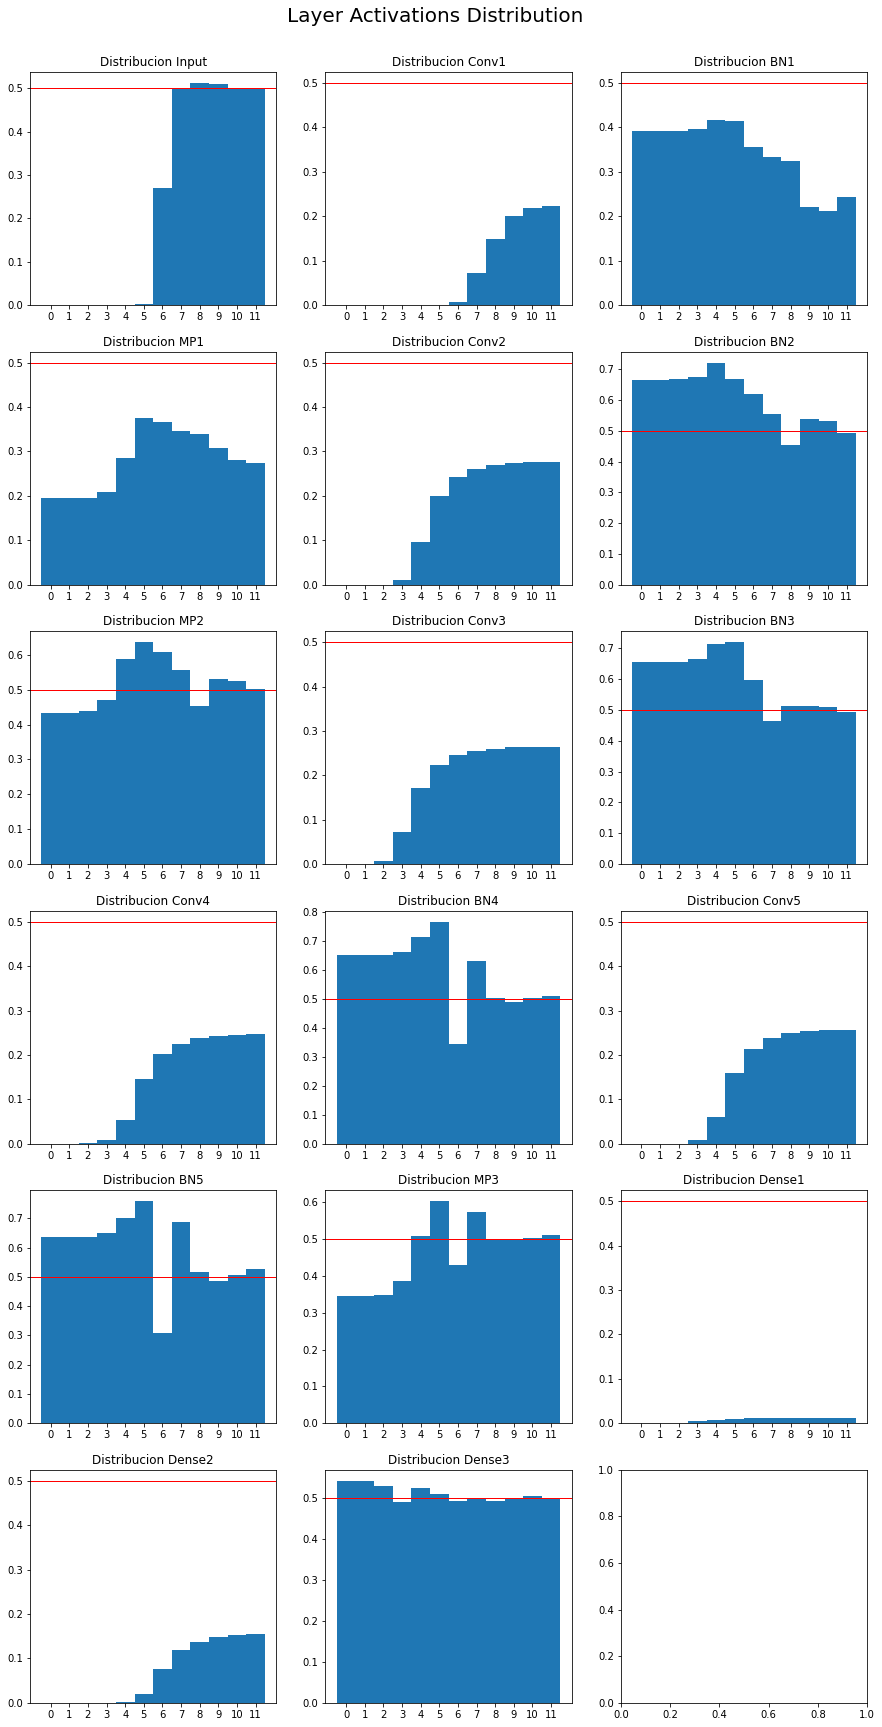

In [83]:
Capas = ['Input','Conv1','BN1','MP1','Conv2','BN2','MP2','Conv3','BN3','Conv4','BN4','Conv5','BN5','MP3','Dense1','Dense2','Dense3']
fig, axs = plt.subplots(6,3,figsize=(15,30))
fig.suptitle('Layer Activations Distribution',fontsize=20, y=0.91)
for row in range(6):
    for col in range(3):
        if 3*row + col < 17:
            Dict = load_obj(Capas[row*3 + col])
            axs[row,col].bar(Dict.keys(), Dict.values(), 1)
            axs[row,col].set_title('Distribucion ' + Capas[row*3 + col])
            axs[row,col].axhline(y=0.5,linewidth=1, color='r')
            axs[row,col].set_xticks(np.array(list(Dict.keys()),dtype=float))
            axs[row,col].set_xticklabels(Dict.keys())